In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
sys.path.append("/Users/julianganzabal/facultad/lab-ml/mllab-tools")
from RNN_utils import encode_io_pairs, chars_to_one_hot, sample
from fnn_helper import PlotLosses

Using TensorFlow backend.


In [2]:
text="HELLO"

In [3]:
chars = sorted(set(text))
print(chars)

['E', 'H', 'L', 'O']


In [4]:
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))
chars_to_one_hot('HE', chars, chars_to_indices, window_size)*1

array([[[0, 1, 0, 0],
        [1, 0, 0, 0]]])

In [5]:
indices_to_chars[np.argmax([1, 0, 0, 0])]

'E'

In [6]:
window_size=1
step_size=1
X, y = encode_io_pairs(text, chars, window_size,step_size)

In [7]:
X.shape

(4, 1, 4)

In [8]:
print(X*1)
print(y*1)

[[[0 1 0 0]]

 [[1 0 0 0]]

 [[0 0 1 0]]

 [[0 0 1 0]]]
[[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]]


# N=4, T=1, D=4

In [9]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [14]:
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1,len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


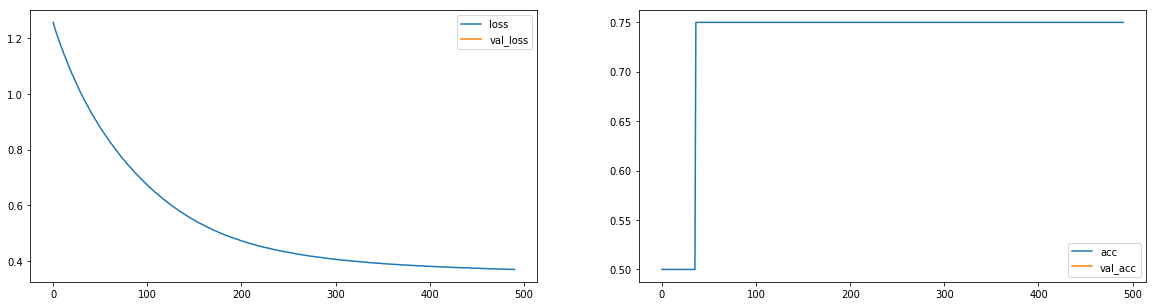

4/4 [==============================] - 0s - loss: 0.3694 - acc: 0.7500     
Epoch 492/500
4/4 [==============================] - 0s - loss: 0.3692 - acc: 0.7500     
Epoch 493/500
4/4 [==============================] - 0s - loss: 0.3689 - acc: 0.7500     
Epoch 494/500
4/4 [==============================] - 0s - loss: 0.3689 - acc: 0.7500     
Epoch 495/500
4/4 [==============================] - 0s - loss: 0.3687 - acc: 0.7500     
Epoch 496/500
4/4 [==============================] - 0s - loss: 0.3687 - acc: 0.7500     
Epoch 497/500
4/4 [==============================] - 0s - loss: 0.3687 - acc: 0.7500     
Epoch 498/500
4/4 [==============================] - 0s - loss: 0.3688 - acc: 0.7500     
Epoch 499/500
4/4 [==============================] - 0s - loss: 0.3686 - acc: 0.7500     
Epoch 500/500
4/4 [==============================] - 0s - loss: 0.3684 - acc: 0.7500     


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model.fit(X,y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [16]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
print(to_predict)
predicted = model.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted)])

[[[0 0 1 0]]]
[[ 0.01186381  0.00552882  0.50175279  0.48085466]]
L


In [17]:
sample([0.4, 0.1, 0.5],0.5, verbose=True)

[ 0.38095238  0.02380952  0.5952381 ]


2

In [18]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model.predict(to_predict)
iterat = 10
temp = 0.2 # 1, 0.5, 0.1, 0.01
for i in range(iterat):
    print(indices_to_chars[sample(predicted[0], temp)])

O
L
O
L
O
O
L
O
L
L


In [19]:
to_predict = chars_to_one_hot('HEL', chars, chars_to_indices, window_size)*1

In [20]:
to_predict.reshape(3,1,4)

array([[[0, 1, 0, 0]],

       [[1, 0, 0, 0]],

       [[0, 0, 1, 0]]])

In [21]:
predicted = model.predict(to_predict.reshape(3,1,4))

In [22]:
predicted

array([[ 0.97516268,  0.00570653,  0.00783198,  0.01129873],
       [ 0.00286766,  0.00119182,  0.9756586 ,  0.02028189],
       [ 0.01186381,  0.00552882,  0.50175279,  0.48085466]], dtype=float32)

## T = 2

In [23]:
window_size = 2
X_2, y_2 = encode_io_pairs(text, chars, window_size,step_size)

In [24]:
model_2 = Sequential()
model_2.add(SimpleRNN(10, input_shape=(2,len(chars))))
model_2.add(Dense(len(chars), activation="softmax"))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


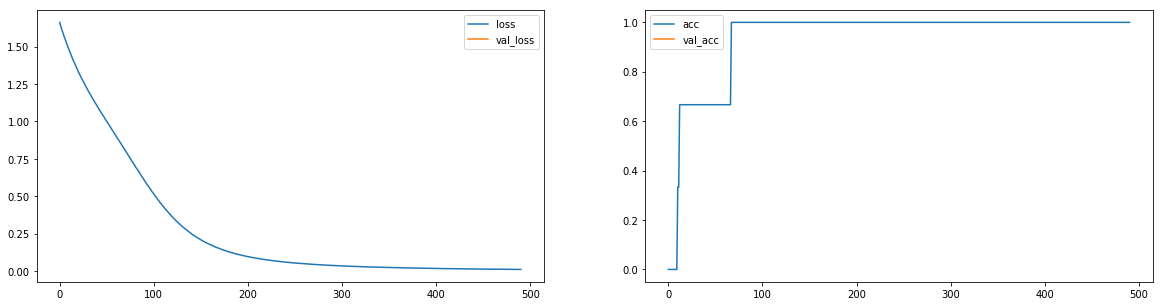

3/3 [==============================] - 0s - loss: 0.0119 - acc: 1.0000     
Epoch 492/500
3/3 [==============================] - 0s - loss: 0.0118 - acc: 1.0000     
Epoch 493/500
3/3 [==============================] - 0s - loss: 0.0118 - acc: 1.0000     
Epoch 494/500
3/3 [==============================] - 0s - loss: 0.0117 - acc: 1.0000     
Epoch 495/500
3/3 [==============================] - 0s - loss: 0.0117 - acc: 1.0000     
Epoch 496/500
3/3 [==============================] - 0s - loss: 0.0116 - acc: 1.0000     
Epoch 497/500
3/3 [==============================] - 0s - loss: 0.0116 - acc: 1.0000     
Epoch 498/500
3/3 [==============================] - 0s - loss: 0.0115 - acc: 1.0000     
Epoch 499/500
3/3 [==============================] - 0s - loss: 0.0115 - acc: 1.0000     
Epoch 500/500
3/3 [==============================] - 0s - loss: 0.0114 - acc: 1.0000     


In [25]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_2.fit(X_2,y_2, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

# Stateful RNN

In [26]:
batch_size=1
model_3 = Sequential()
model_3.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (1, 10)                   150       
_________________________________________________________________
dense_4 (Dense)              (1, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [27]:
X.shape

(4, 1, 4)

In [28]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_3.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_3.reset_states()

Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3519 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3361 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3217 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3075 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2935 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2798 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2663 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2530 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2396 - acc: 0.2500         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2259 - acc: 0.5000         
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2129 - acc: 0.5000         
Epoch 1/1


# Voy ingresando de a uno

In [29]:
window_size=1
model_3.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.88608217  0.02628169  0.04474477  0.04289145]]


'E'

In [30]:
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.10466907  0.0245551   0.86466044  0.00611531]]


'L'

In [31]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[  8.34205130e-04   2.03162013e-03   9.68337476e-01   2.87966859e-02]]


'L'

In [32]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.00665629  0.02078857  0.06094405  0.91161102]]


'O'

Algunas pruebas mas

In [33]:
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.32097781  0.05783277  0.20528252  0.41590691]]


'O'

In [34]:
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

[[ 0.32097781  0.05783277  0.20528252  0.41590691]]
O
[[ 0.84779221  0.03554731  0.01574422  0.10091618]]
E


In [35]:
# Interesante! HEL -> L, pero EL -> O (No es markov)
model_3.reset_states()
#to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
#predicted = model_3.predict(to_predict)
#print(predicted)
#print(indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

[[ 0.034667    0.01116004  0.83205271  0.12212034]]
L
[[ 0.00490081  0.01398773  0.47524422  0.50586724]]
O


# Cambio batch size

In [37]:
X_4 = X
y_4 = y
batch_size=len(X)
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (4, 10)                   150       
_________________________________________________________________
dense_5 (Dense)              (4, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(500):
    model_4.fit(X_4, y_4, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_4.reset_states()

Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4907 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4848 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4790 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4733 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4675 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4618 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4561 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4504 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4448 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4392 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4337 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4282 - acc: 0.2500
Epoch 1/1
4/4 [=============

In [39]:
model_3.reset_states()
#to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
#predicted = model_3.predict(to_predict)
#print(predicted)
#print(indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)

[[ 0.88608217  0.02628169  0.04474477  0.04289145]]


# TimeDistributed wrapper
https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

# Pad sequences
"The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras."
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

# Encoder decoder
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

# Sentiment analysis con CNN y LSTM
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Word-level language model

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# return_sequence vs return_state
https://www.quora.com/What-is-the-difference-between-states-and-outputs-in-LSTM

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

# Truncated BPTT 
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/